# Business Ties

Can we piece the business community/ economy of Eigg together from data online

In [9]:
%matplotlib inline
import sys
sys.path.insert(1,'../Utilities')
# notebook
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import networkx as nx
import json
from math import sin, cos, sqrt, atan2, radians
from utils import *
from data import *
#make the graphs bigger
pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

In [10]:
def buildNamedBusinessGraph(inferred=False):
    G = nx.Graph()
    
    data = uninferredNamesGraph()
    if inferred:
        data = inferredNamesGraph()
        
    names = data.keys()
    for k,i in enumerate(names): G.add_node(i)
        
    for name1 in names:
        for name2 in names:
            if name1 != name2 and len(list(set(data[name1]) & set(data[name2]))):
                G.add_edge(name1,name2)
    
    labels={}
    for k,i in enumerate(names): labels[i] = i
    return G, labels

def buildBusinessGraph(inferred=False):
    G = nx.Graph()
    data = uninferredNamesGraph()
    if inferred:
        data = inferredNamesGraph()
    
    names = data.keys()
    businesses = list(Counter([item for sublist in data.values() for item in sublist]).keys())
    
    businessMembers = defaultdict(list)
    for b in businesses:
        for name in names:
            if b in data[name]:
                businessMembers[b].append(name)
            
    businessList = businessMembers.keys()
    for k,i in enumerate(businessList): G.add_node(i)
    for b1 in businessList:
        for b2 in businessList:
            if b1 != b2 and len(list(set(businessMembers[b1]) & set(businessMembers[b2]))):
                G.add_edge(b1,b2)
    
    labels={}
    for k,i in enumerate(businessList): labels[i] = i
    return G, labels

62


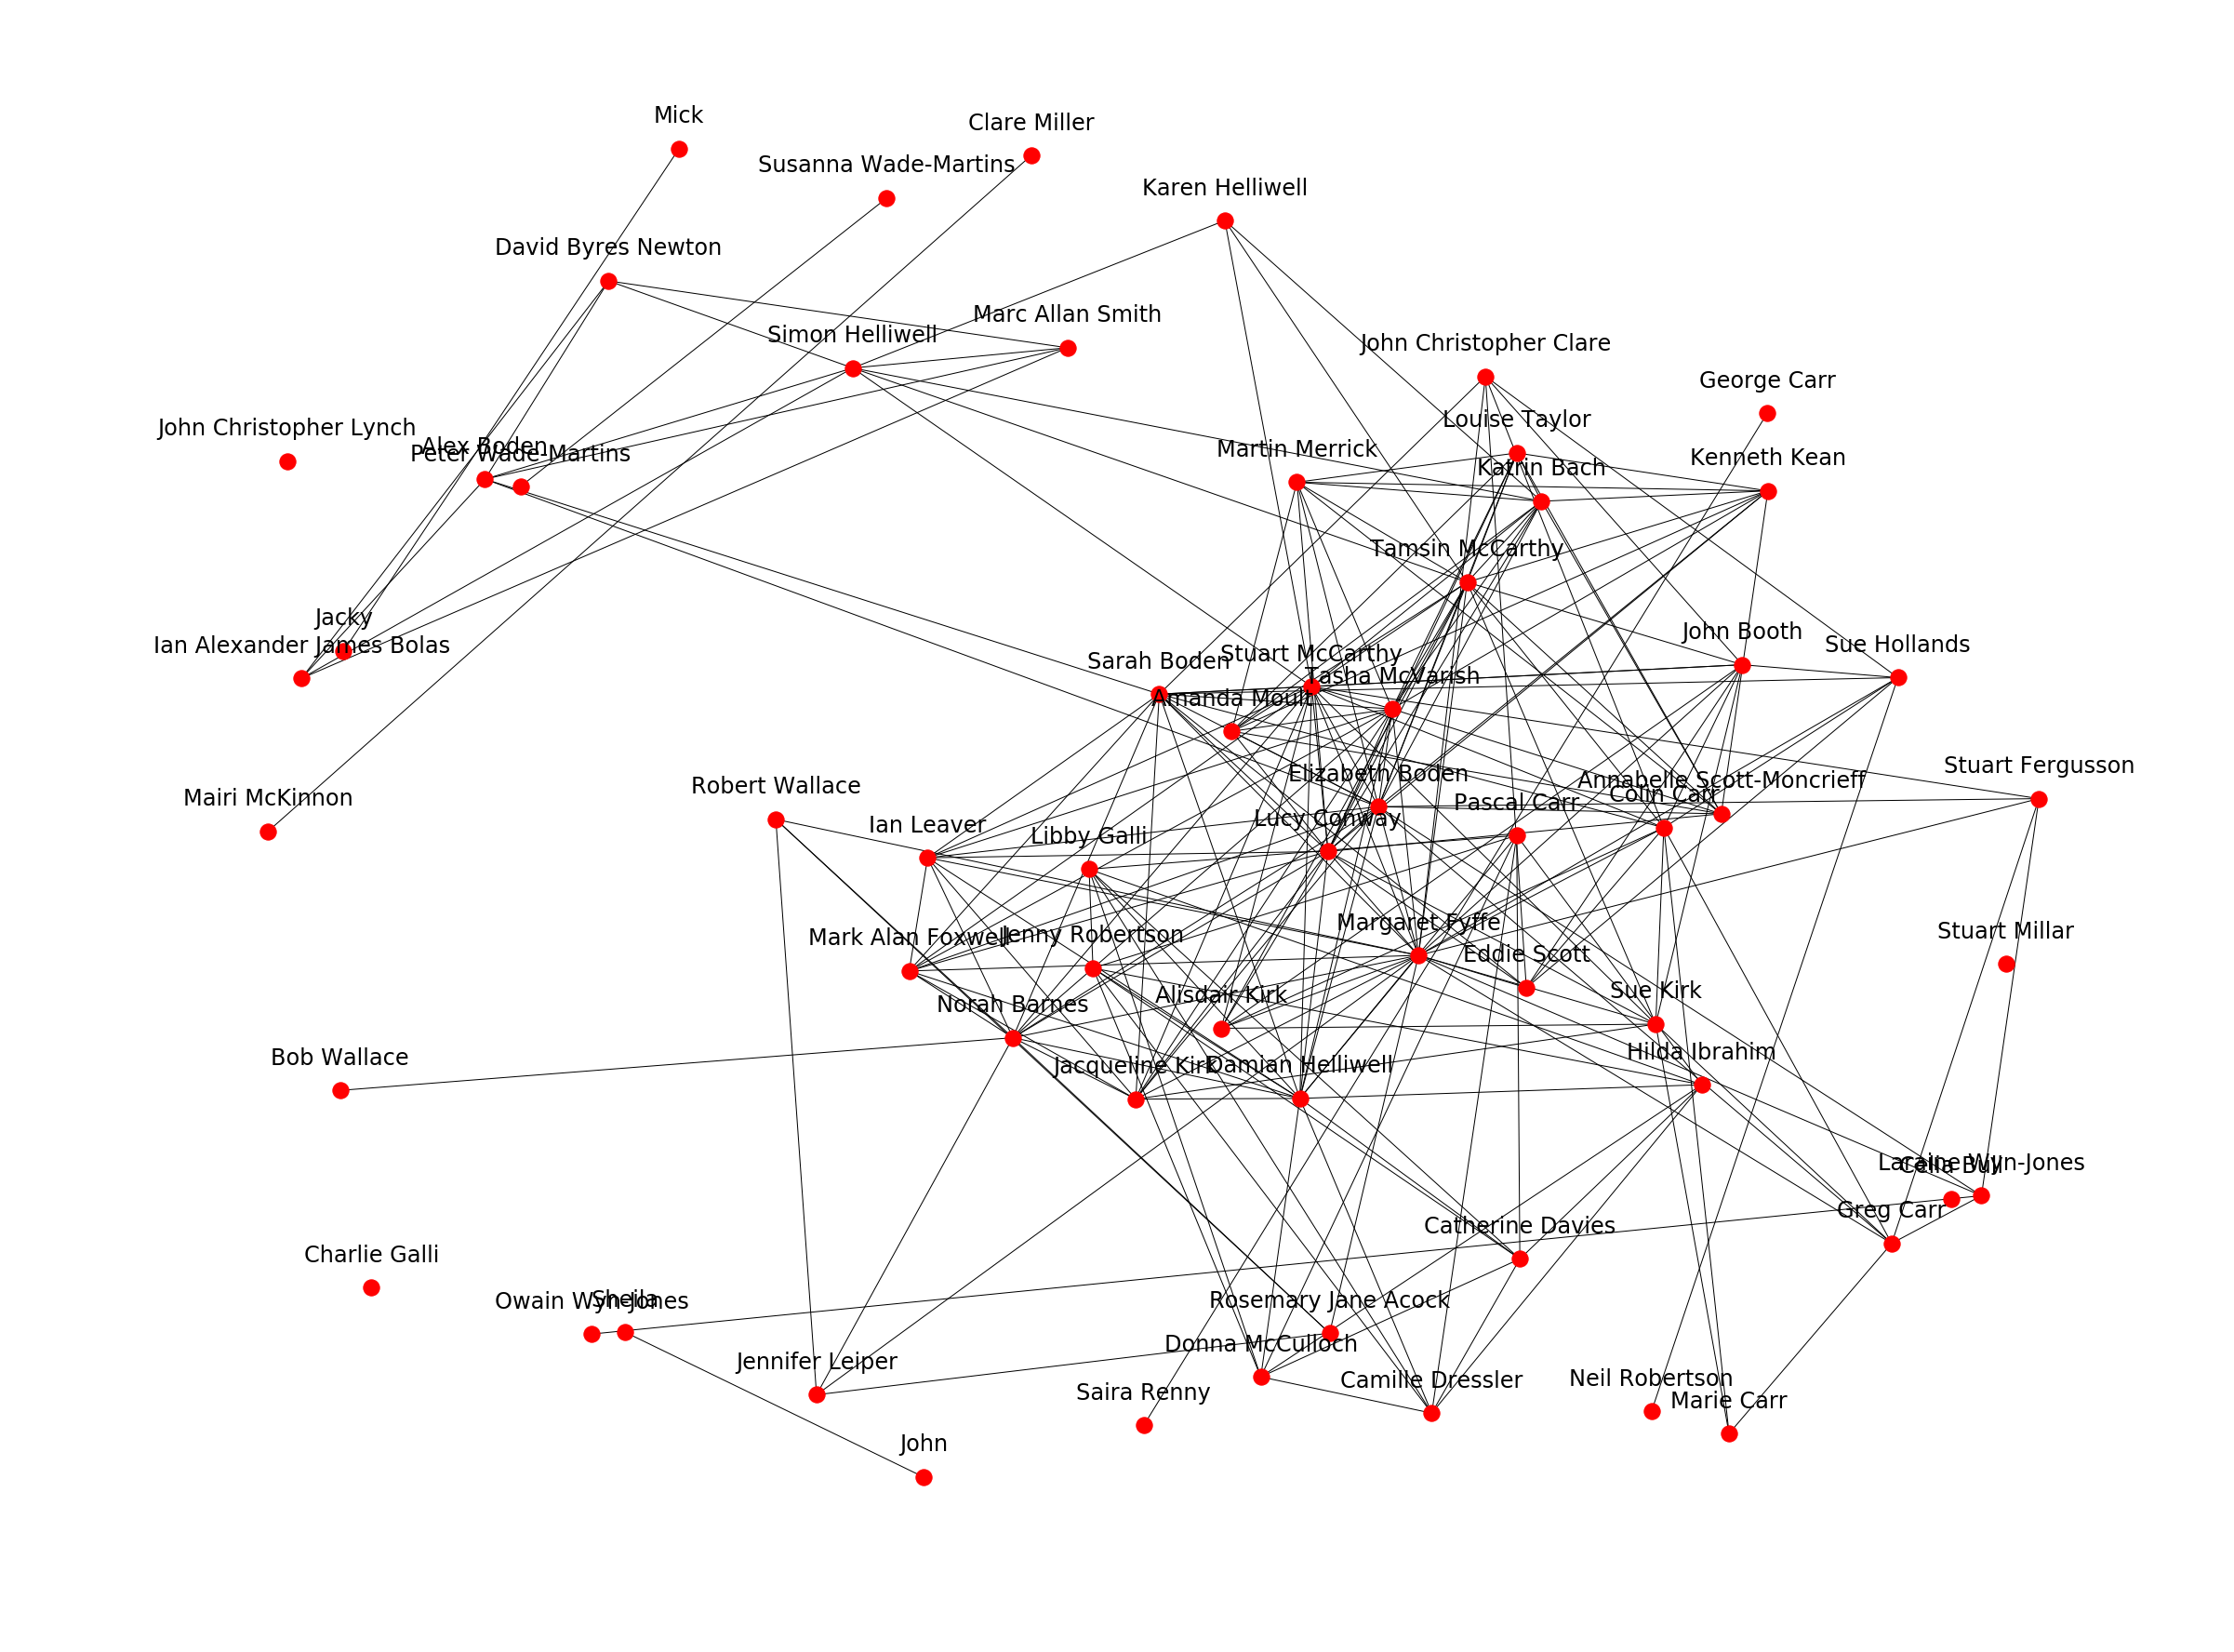

In [11]:
G, labels= buildNamedBusinessGraph()
print(len(G.degree))
pos=nx.spring_layout(G,k=1)
#nx.draw_networkx_labels(G,pos,labels,font_size=16)
nx.draw(G,pos)
for label in pos:
    x,y = pos[label]
    plt.text(x,y+0.035,s=label,horizontalalignment='center',fontsize=24)

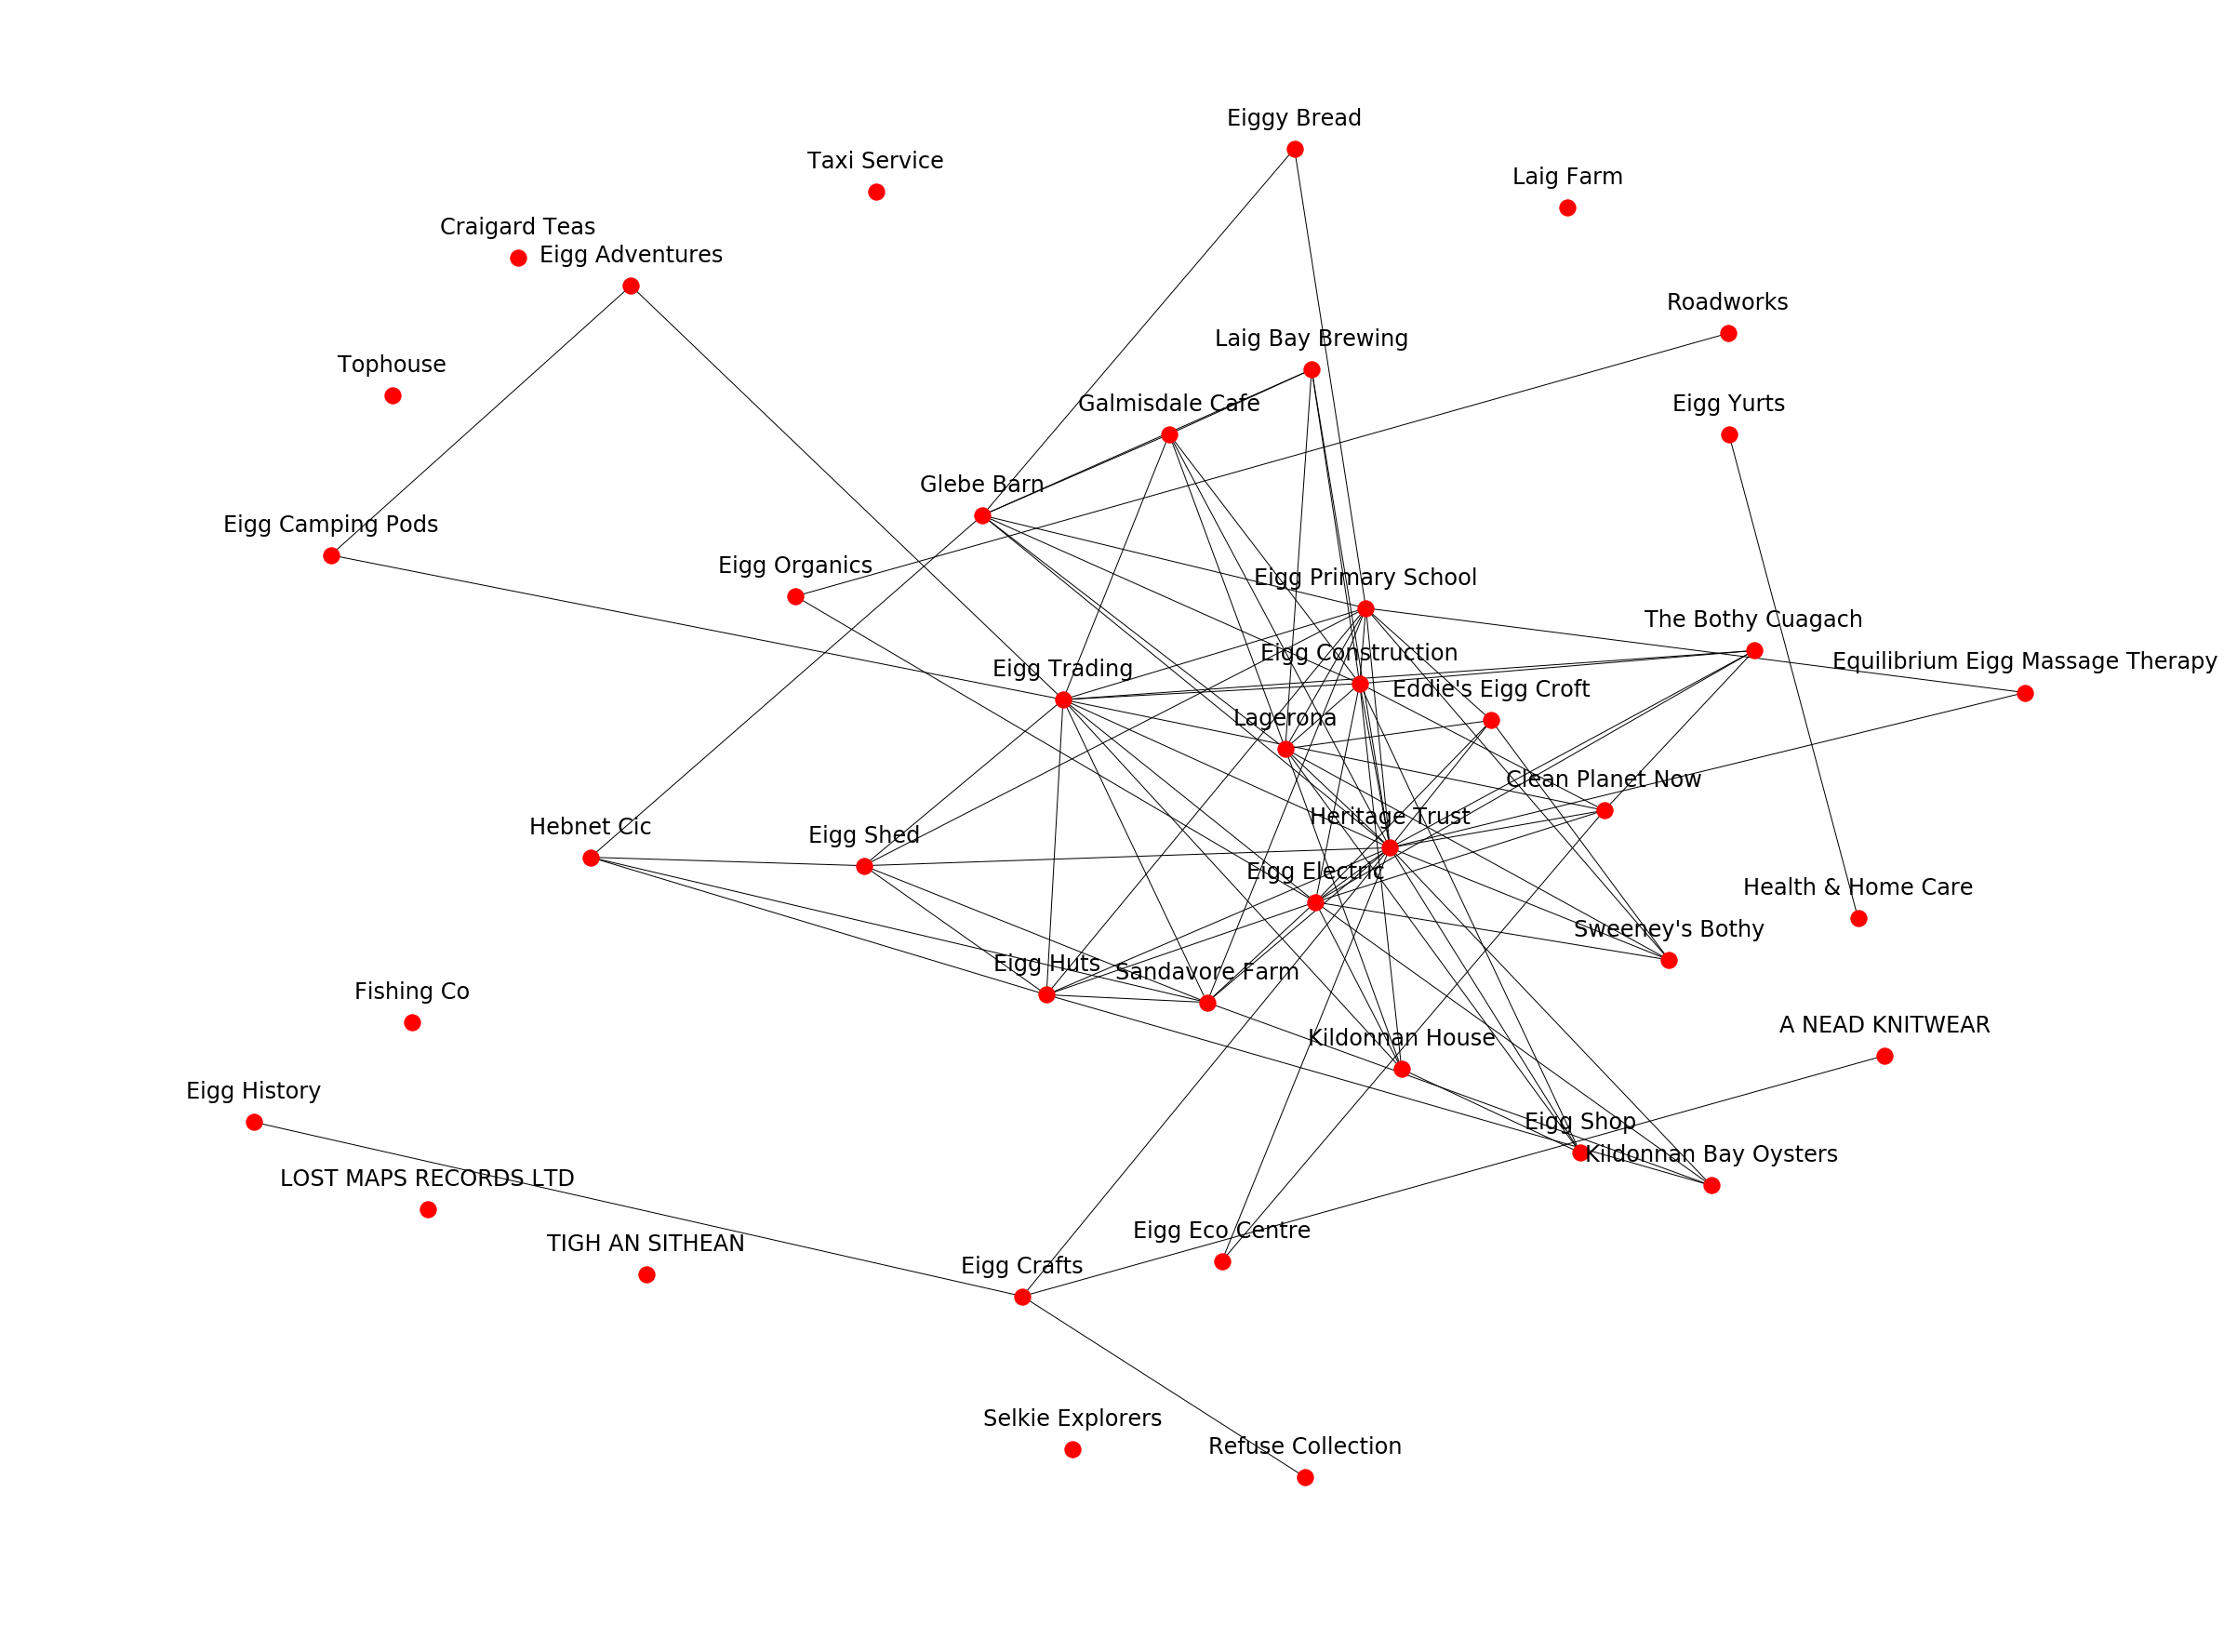

In [12]:
G, labels= buildBusinessGraph()
pos=nx.spring_layout(G,k=1)
nx.draw(G,pos)
for label in pos:
    x,y = pos[label]
    plt.text(x,y+0.035,s=label,horizontalalignment='center',fontsize=24)

In [13]:
list(G.edges())

[('Heritage Trust', 'Eigg Crafts'),
 ('Heritage Trust', 'Clean Planet Now'),
 ('Heritage Trust', 'Eigg Electric'),
 ('Heritage Trust', 'Eigg Trading'),
 ('Heritage Trust', 'Eigg Construction'),
 ('Heritage Trust', 'The Bothy Cuagach'),
 ('Heritage Trust', 'Eigg Eco Centre'),
 ('Heritage Trust', 'Eigg Huts'),
 ('Heritage Trust', 'Eigg Shed'),
 ('Heritage Trust', 'Eigg Primary School'),
 ('Heritage Trust', 'Sandavore Farm'),
 ('Heritage Trust', 'Lagerona'),
 ('Heritage Trust', "Sweeney's Bothy"),
 ('Heritage Trust', "Eddie's Eigg Croft"),
 ('Heritage Trust', 'Kildonnan Bay Oysters'),
 ('Heritage Trust', 'Eigg Shop'),
 ('Heritage Trust', 'Glebe Barn'),
 ('Heritage Trust', 'Laig Bay Brewing'),
 ('Heritage Trust', 'Galmisdale Cafe'),
 ('Heritage Trust', 'Equilibrium Eigg Massage Therapy'),
 ('Eigg Crafts', 'A NEAD KNITWEAR'),
 ('Eigg Crafts', 'Refuse Collection'),
 ('Eigg Crafts', 'Eigg History'),
 ('Clean Planet Now', 'Eigg Electric'),
 ('Clean Planet Now', 'Eigg Trading'),
 ('Clean Planet

(62, 62)

242


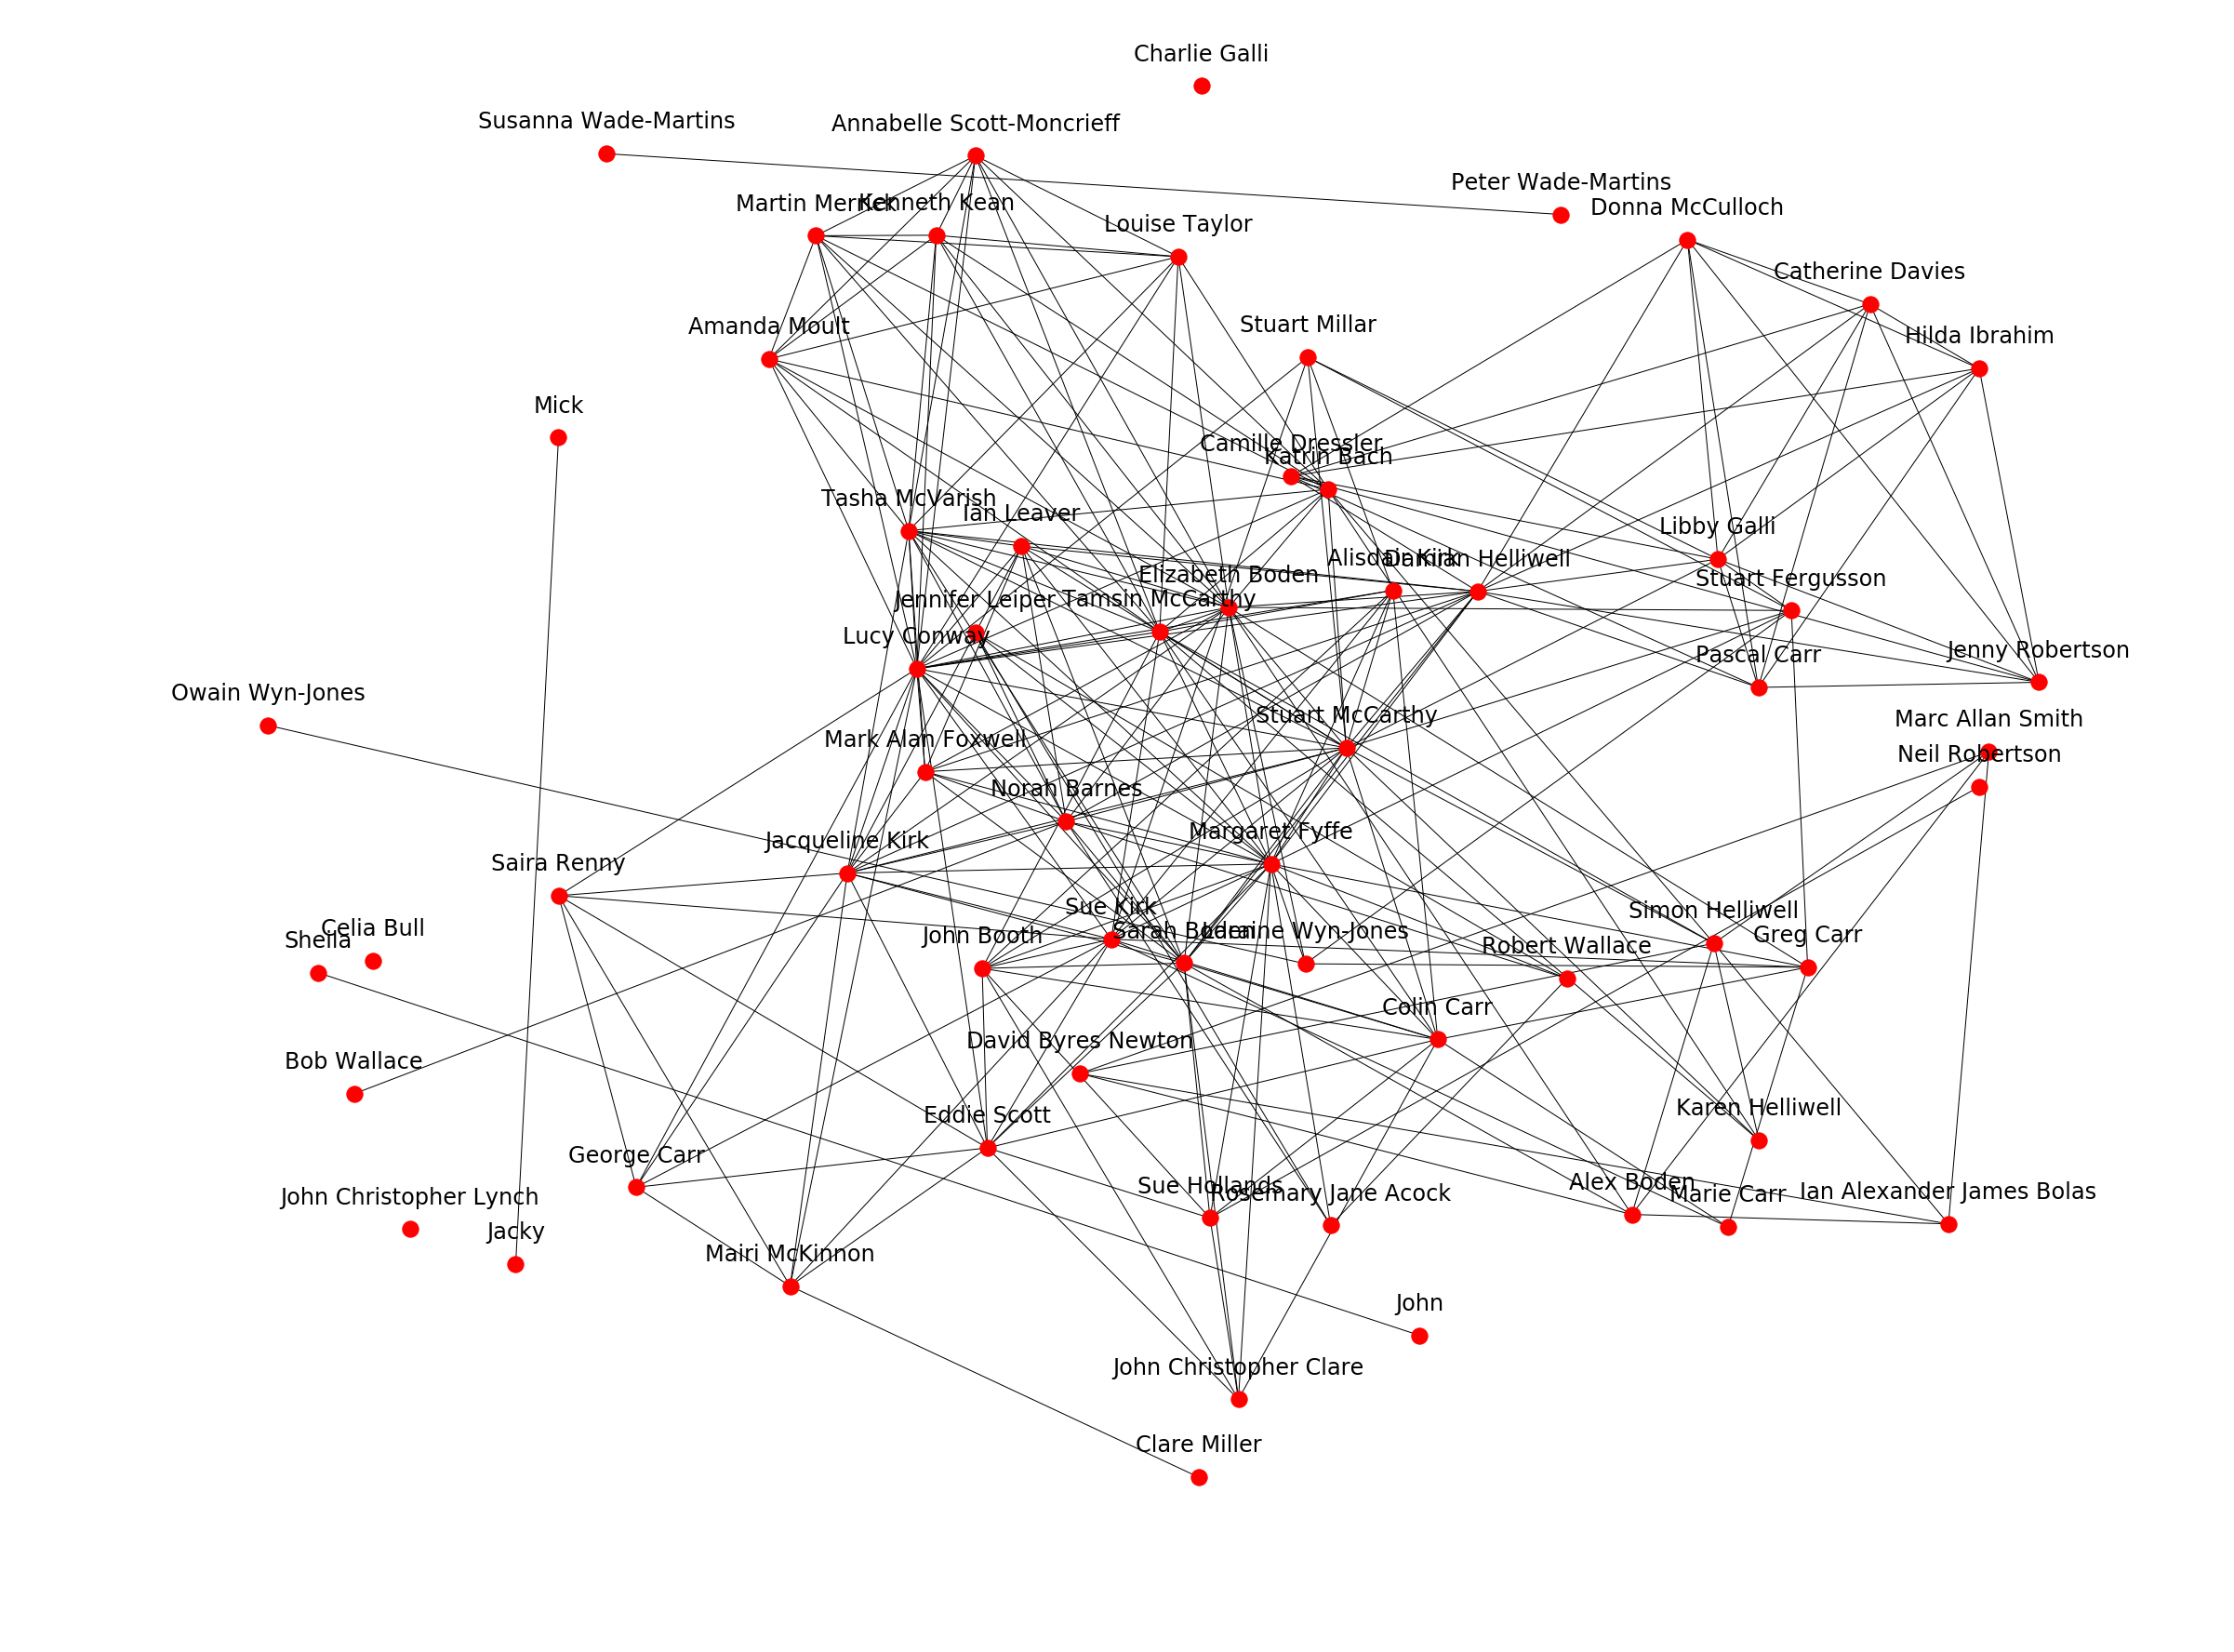

In [14]:
G, labels= buildNamedBusinessGraph(inferred=True)
pos=nx.spring_layout(G,k=1)
saveGraphToFile(G,"namedBusinessNet.txt")
#nx.draw_networkx_labels(G,pos,labels,font_size=16)
nx.draw(G,pos)
print(len(G.edges()))
for label in pos:
    x,y = pos[label]
    plt.text(x,y+0.035,s=label,horizontalalignment='center',fontsize=24)

(41, 41)



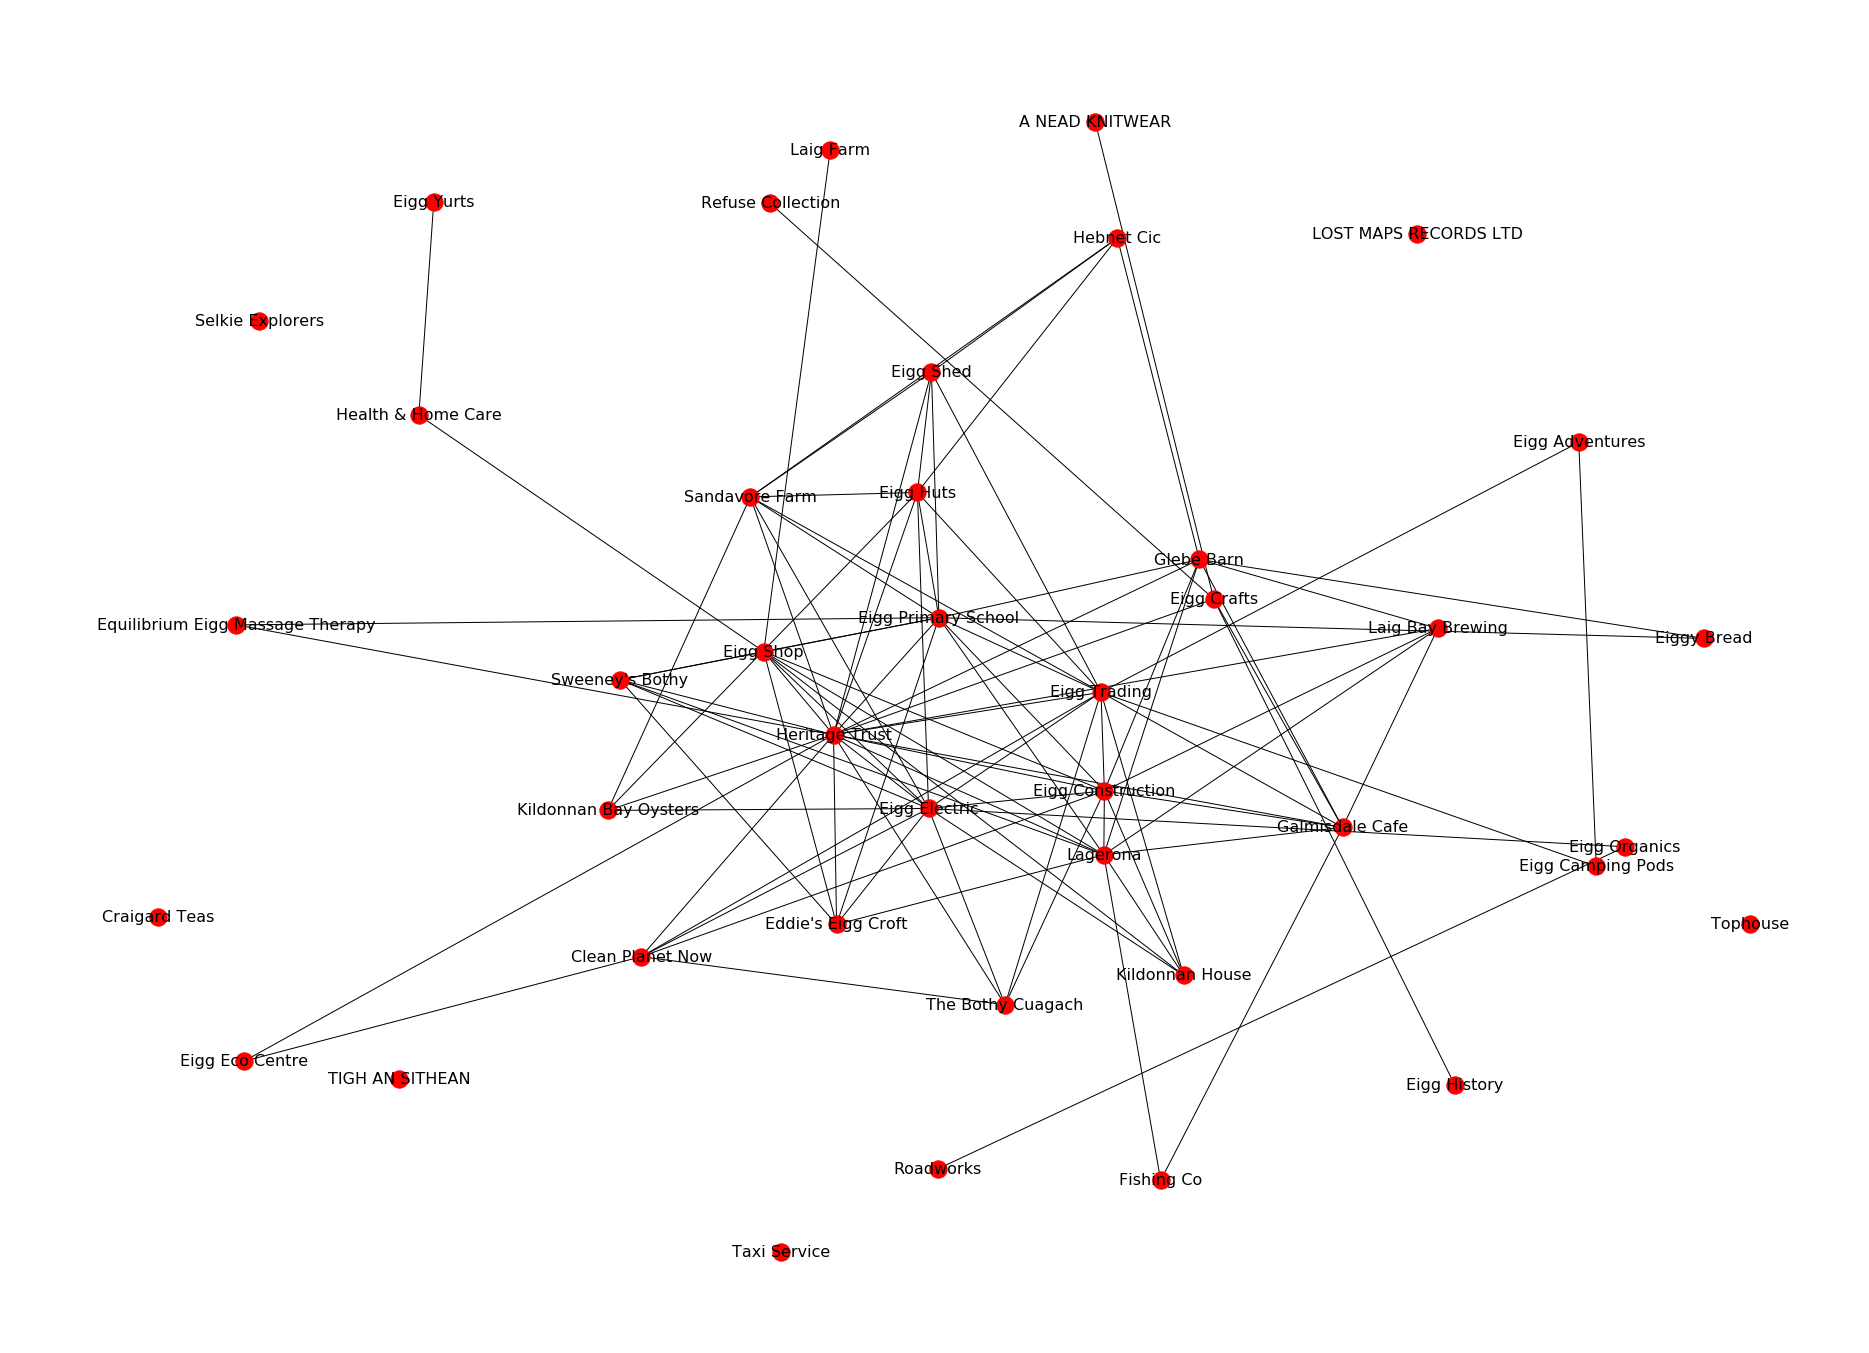

In [15]:
G, labels= buildBusinessGraph(inferred=True)
pos=nx.spring_layout(G,k=1)
saveGraphToFile(G,"businessNet.txt")
nx.draw_networkx_labels(G,pos,labels,font_size=16)
nx.draw(G,pos)

In [16]:
d = inferredBusinessLocations()
dict_ = {}

for item in d:
    one,two = d[item].split(",")
    dict_[item] = [float(one),float(two)]

generateMapJSON([('./fullColMarkers/marker76.png',list(dict_.values()),list(dict_.keys()))],[(dict_,G)],'businessByLocation.txt')